## Installing libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import random
import warnings
import string
import datetime
warnings.filterwarnings("ignore")
%matplotlib inline

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

## Loading, Viewing and Making Sense of Dataset

We will now load the datasets, consisting of image files and the csv files. The datasets has been conveniently separated into train, validation and test sets.

In [2]:
train_name = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
test_name = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')
val_name = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')

Let's visualize the headings of the csv files.

In [3]:
train_name.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


Next, we will see the descriptions of the data.

In [4]:
train_name.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_00001.jpg,THOMAS
freq,1,1825


In [5]:
test_name.describe()

,FILENAME,IDENTITY
count,41370,41300
unique,41370,20279
top,TEST_0001.jpg,THOMAS
freq,1,227


We will also look at the information about our data.

In [6]:
train_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [7]:
test_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41300 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


We will examine the dimensions of our datasets.

In [8]:
train_name.shape

(330961, 2)

In [9]:
test_name.shape

(41370, 2)

In [10]:
val_name.shape

(41370, 2)

We will also examine the types of data we are dealing with.

In [11]:
train_name.dtypes

FILENAME    object
IDENTITY    object
dtype: object

We will also see the indices of the columns

In [12]:
train_name.columns

Index(['FILENAME', 'IDENTITY'], dtype='object')

Finally, we will look at some of the examples of the images of handwritten names from, say, train dataset.

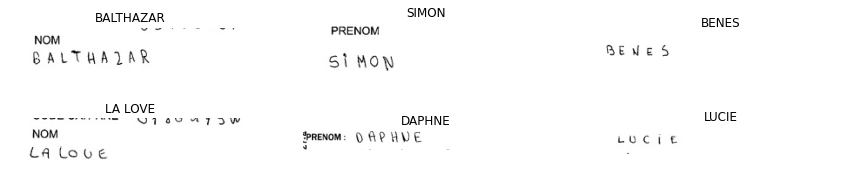

In [13]:
plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_name.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Data Cleaning

We will now check for null entries in the csv files.

In [14]:
print("Number of NaNs in the train dataset is: ", train_name['IDENTITY'].isnull().sum())
print("Number of NaNs in the validation dataset is: ", val_name['IDENTITY'].isnull().sum())
print("Number of NaNs in the test dataset is: ", test_name['IDENTITY'].isnull().sum())

Number of NaNs in the train dataset is:  565
Number of NaNs in the validation dataset is:  78
Number of NaNs in the test dataset is:  70


Now get rid of all the null entries.

In [15]:
train_name.dropna(axis=0, inplace=True)
val_name.dropna(axis=0, inplace=True)
test_name.dropna(axis=0, inplace=True)

There are also some images that are unreadable. We will look at some examples here.

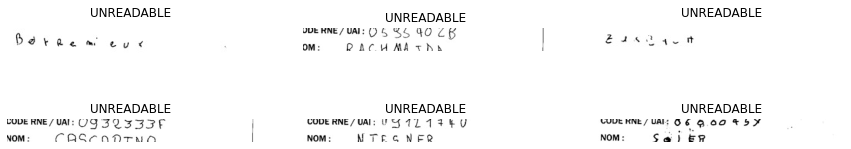

In [16]:
unreadable = train_name[train_name['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop = True)

plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

Now we drop unreadable images in the csv dataset.

In [17]:
train_name = train_name[train_name['IDENTITY'] != 'UNREADABLE']
val_name = val_name[val_name['IDENTITY'] != 'UNREADABLE']
test_name = test_name[test_name['IDENTITY'] != 'UNREADABLE']

Set all labels to uppercases for uniformity in data.

In [18]:
train_name['IDENTITY'] = train_name['IDENTITY'].str.upper()
val_name['IDENTITY'] = val_name['IDENTITY'].str.upper()
test_name['IDENTITY'] = test_name['IDENTITY'].str.upper()

Reset the index and the data cleaning is done.

In [19]:
train_name.reset_index(inplace = True, drop = True)
val_name.reset_index(inplace = True, drop = True)
test_name.reset_index(inplace = True, drop = True)

## Image Preprocessing

The image are loaded as grayscale and reshaped to width 265 and height 64. If images are larger than this dimension, we will crop the image. if the image is smaller than this dimension, we will add white pixels padding and rotate to (x, y). Finally, all images are normalized to [0, 1].

In [20]:
def image_processing(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 
    
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
        
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

We will train the model on 60,000 train images and validate on 3,000 images. We will then test on 3,000 images.

In [21]:
train_size = 30000
val_size = 3000
test_size = 3000

train_x = []
val_x = []
test_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/' + train_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255.
    train_x.append(image)
    
for i in range(val_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/' + val_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255.
    val_x.append(image)
    
for i in range(test_size):
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/' + test_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255.
    test_x.append(image)
    
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
val_x = np.array(val_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

## Character processing

We will now process the strings of names by converting them into numbers via a systematic sets of rules (CTC loss) for text recognition. The alphabets contain A-Z and three special characters (- ' and space).

In [22]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input name
num_characters = len(alphabets) + 1 # the plus one is to account for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted names

def name_to_num(name):
    name_num = []
    for ch in name:
        name_num.append(alphabets.find(ch))
    return np.array(name_num)

def num_to_name(num):
    name = ""
    for ch in num:
        if ch == -1: # CTC blank
            break
        else:
            name += alphabets[ch]
    return name

Here we will create 4 variables for each of the sets (train, validation, test). For instance:

* **train_y** contains the true numerical representation of name and padded with -1. The length is equal to max_str_len.
* **train_name_len** is the length of name without padding.
* **train_input_len** is the length of each predicted name. The length of all the predicted names is constant and is (num_of_timestamps - 2).
* **train_output** is the output for the ML model.

In [23]:
train_y = np.ones([train_size, max_str_len]) * -1
train_name_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_name_len[i] = len(train_name.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train_name.loc[i, 'IDENTITY'])] = name_to_num(train_name.loc[i, 'IDENTITY'])

val_y = np.ones([val_size, max_str_len]) * -1
val_name_len = np.zeros([val_size, 1])
val_input_len = np.ones([val_size, 1]) * (num_of_timestamps-2)
val_output = np.zeros([val_size])

for i in range(val_size):
    val_name_len[i] = len(val_name.loc[i, 'IDENTITY'])
    val_y[i, 0:len(val_name.loc[i, 'IDENTITY'])] = name_to_num(val_name.loc[i, 'IDENTITY'])

test_y = np.ones([test_size, max_str_len]) * -1
test_name_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_name_len[i] = len(test_name.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test_name.loc[i, 'IDENTITY'])] = name_to_num(test_name.loc[i, 'IDENTITY'])

## Building our hybrid CNN + RNN model

We are now ready to build our machine learning model. We will use CNN to process images (as our x variable) and connect it to RNN (to process our y variable, i.e., names and characters). We will employ deep CNN architecture (3 layers) and shallow RNN architecture (2 layers). We will also define a CTC loss function beforehand.

In [24]:
def ctc_lambda_func(args):
    y_pred, names, input_length, name_length = args
    
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(names, y_pred, input_length, name_length)

input_data = Input(shape=(256, 64, 1), name='input')
    
# CNN
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='max1')(inner)
    
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='max2')(inner)
inner = Dropout(0.3)(inner)
    
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1,2), name='max3')(inner)
inner = Dropout(0.3)(inner)
    
# CNN to RNN
inner = Reshape(target_shape = ((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)
    
# RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)
    
# Output
inner = Dense(num_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)
    
model = Model(inputs=input_data, outputs=y_pred)

# Now include the ctc loss function and compile
names = Input(name='gtruth_names', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
name_length = Input(name='name_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, names, input_length, name_length])
model_final = Model(inputs=[input_data, names, input_length, name_length], outputs=ctc_loss)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0001))

2022-11-16 03:35:04.769781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:35:04.885881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:35:04.886762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:35:04.888066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Training our model

We are now ready to train our model.

In [25]:
model_final.fit(x = [train_x, train_y, train_input_len, train_name_len], y=train_output, validation_data = ([val_x, val_y, val_input_len, val_name_len], val_output), epochs=60, batch_size=128)

2022-11-16 03:35:16.120687: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1966080000 exceeds 10% of free system memory.
2022-11-16 03:35:18.555050: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-11-16 03:35:25.386551: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


235/235 [==============================] - ETA: 0s - loss: 25.2418

2022-11-16 03:36:11.580681: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 196608000 exceeds 10% of free system memory.
2022-11-16 03:36:11.725934: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 196608000 exceeds 10% of free system memory.


235/235 [==============================] - 57s 184ms/step - loss: 25.2418 - val_loss: 20.9152
Epoch 2/60
235/235 [==============================] - 41s 173ms/step - loss: 20.1442 - val_loss: 20.1390
Epoch 3/60
235/235 [==============================] - 39s 168ms/step - loss: 19.7961 - val_loss: 19.7664
Epoch 4/60
235/235 [==============================] - 39s 167ms/step - loss: 19.3940 - val_loss: 19.3719
Epoch 5/60
235/235 [==============================] - 39s 167ms/step - loss: 18.7597 - val_loss: 18.2561
Epoch 6/60
235/235 [==============================] - 40s 170ms/step - loss: 17.6923 - val_loss: 17.2527
Epoch 7/60
235/235 [==============================] - 40s 170ms/step - loss: 16.3784 - val_loss: 16.2180
Epoch 8/60
235/235 [==============================] - 39s 166ms/step - loss: 14.6740 - val_loss: 14.4633
Epoch 9/60
235/235 [==============================] - 39s 168ms/step - loss: 12.7573 - val_loss: 11.8044
Epoch 10/60
235/235 [==============================] - 40s 170ms/s

## Performance on the validation dataset

We will now use our trained model on the validation dataset to measure the accuracy of our model.

In [26]:
preds = model.predict(val_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])

prediction = []
for i in range(val_size):
    prediction.append(num_to_name(decoded[i]))
    
y_true = val_name.loc[0:val_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(val_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr:
        correct += 1
        
print('Correct characters predicted: %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted: %.2f%%' %(correct*100/val_size))

2022-11-16 04:15:53.206733: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 196608000 exceeds 10% of free system memory.
2022-11-16 04:15:53.313834: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 196608000 exceeds 10% of free system memory.


Correct characters predicted: 81.75%
Correct words predicted: 67.73%


## Examples of prediction on test set

We will visualize some examples of our model's prediction on test dataset

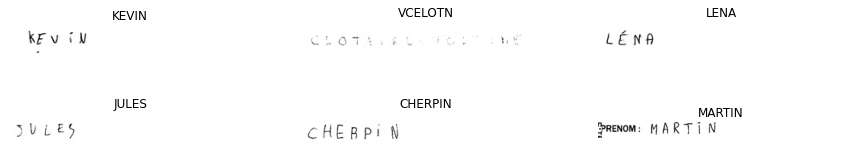

In [27]:
plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    
    image = image_processing(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length = np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
    plt.title(num_to_name(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
model.save_weights("handwriting_model.weights.h5")